# Brain Tumor MRI Image Classification Using VGG16 - Accuracy 97%

### Import Necessary Libraries

In [2]:
# For Data Processing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image, ImageEnhance
import cv2
import os
import random
from tqdm import tqdm

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt


### Defining Labels

In [3]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']  #Brain Tumor Types

### Loading Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.chdir("/content/drive/My Drive/Colab Notebooks/")
!ls

 BrainTumorDataset
'Brain Tumor MRI Image Classification using VGG16 (Accuracy - 97%).ipynb'
'Brain Tumor MRI Image Classification using VGG16.ipynb'
 model.png


In [6]:
train_dir = '/content/drive/My Drive/Colab Notebooks/BrainTumorDataset/Training/' #Training Dataset Exact File Location 
test_dir = '/content/drive/My Drive/Colab Notebooks/BrainTumorDataset/Testing/' #Testing Dataset Exact File Location

### Reading Training Dataset

In [7]:
train_paths = [] #Training Dataset
train_labels = [] #Training Labels

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

### Visualization of Training Dataset

Text(0.5, 1.0, 'Visualizing Training Dataset')

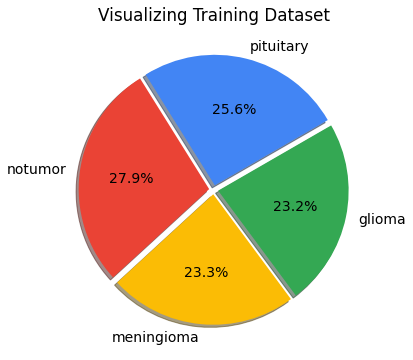

In [9]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.035,0.035,0.035,0.035),
        startangle=30,shadow = True);
plt.title("Visualizing Training Dataset")

### Reading Testing Dataset

In [ ]:
test_paths = [] #Testing Dataset
test_labels = [] #testing Labels

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

### Visualization of Testing Dataset

Text(0.5, 1.0, 'Visualizing Testing Dataset')

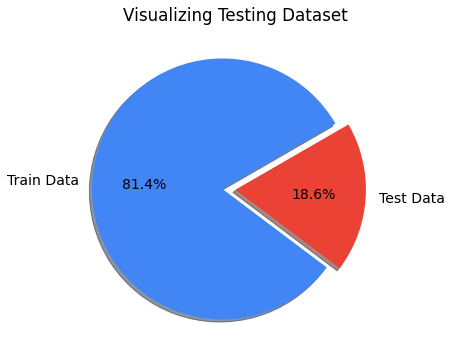

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train Data','Test Data'],
        colors=colors, autopct='%.1f%%', explode=(0.1,0),
        startangle=30,shadow = True);
plt.title("Visualizing Testing Dataset")

### Data Augmentation

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

### Visualization of Brain Tumor MRI Images

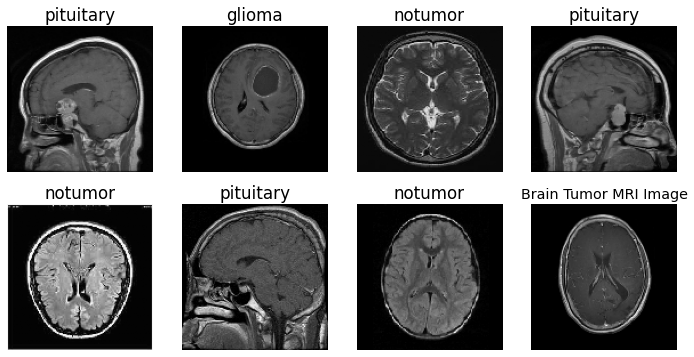

In [ ]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.title("Brain Tumor MRI Image")
plt.show()

### Data Generator Helps Augment Images, Normalization

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

### Building Model Using VGG16 for Transfer Learning

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
Non

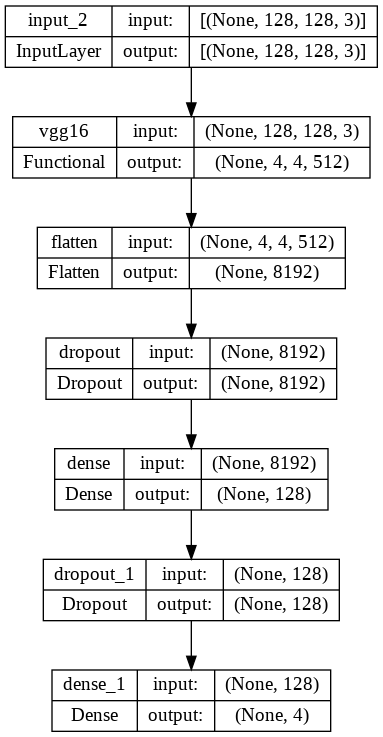

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

### Training the Model

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 6
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/6
287/287 [==============================] - 1304s 5s/step - loss: 0.4487 - sparse_categorical_accuracy: 0.8277
Epoch 2/6
287/287 [==============================] - 1297s 5s/step - loss: 0.2091 - sparse_categorical_accuracy: 0.9240
Epoch 3/6
287/287 [==============================] - 1325s 5s/step - loss: 0.1497 - sparse_categorical_accuracy: 0.9428
Epoch 4/6
287/287 [==============================] - 1254s 4s/step - loss: 0.0993 - sparse_categorical_accuracy: 0.9621
Epoch 5/6
287/287 [==============================] - 1230s 4s/step - loss: 0.0816 - sparse_categorical_accuracy: 0.9696
Epoch 6/6
287/287 [==============================] - 1232s 4s/step - loss: 0.0783 - sparse_categorical_accuracy: 0.9703


### Accuracy and Loss Visualization

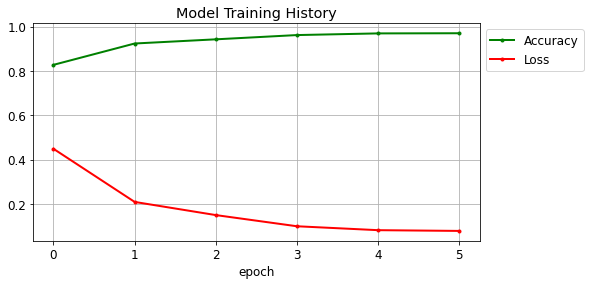

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Evaluating Model with Test Samples

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/41 [00:00<?, ?it/s]

1/1 [==============================] - 6s 6s/step


  2%|▏         | 1/41 [00:11<07:52, 11.81s/it]

1/1 [==============================] - 8s 8s/step


  5%|▍         | 2/41 [00:25<08:26, 13.00s/it]

1/1 [==============================] - 5s 5s/step


  7%|▋         | 3/41 [00:37<07:50, 12.38s/it]

1/1 [==============================] - 5s 5s/step


 10%|▉         | 4/41 [00:49<07:35, 12.30s/it]

1/1 [==============================] - 5s 5s/step


 12%|█▏        | 5/41 [01:01<07:17, 12.16s/it]

1/1 [==============================] - 7s 7s/step


 15%|█▍        | 6/41 [01:14<07:18, 12.51s/it]

1/1 [==============================] - 5s 5s/step


 17%|█▋        | 7/41 [01:25<06:51, 12.11s/it]

1/1 [==============================] - 5s 5s/step


 20%|█▉        | 8/41 [01:37<06:35, 11.97s/it]

1/1 [==============================] - 5s 5s/step


 22%|██▏       | 9/41 [01:48<06:16, 11.76s/it]

1/1 [==============================] - 6s 6s/step


 24%|██▍       | 10/41 [02:01<06:18, 12.20s/it]

1/1 [==============================] - 5s 5s/step


 27%|██▋       | 11/41 [02:14<06:05, 12.19s/it]

1/1 [==============================] - 5s 5s/step


 29%|██▉       | 12/41 [02:26<05:51, 12.13s/it]

1/1 [==============================] - 5s 5s/step


 32%|███▏      | 13/41 [02:38<05:40, 12.16s/it]

1/1 [==============================] - 5s 5s/step


 34%|███▍      | 14/41 [02:50<05:25, 12.05s/it]

1/1 [==============================] - 5s 5s/step


 37%|███▋      | 15/41 [03:02<05:14, 12.11s/it]

1/1 [==============================] - 5s 5s/step


 39%|███▉      | 16/41 [03:14<04:59, 11.96s/it]

1/1 [==============================] - 5s 5s/step


 41%|████▏     | 17/41 [03:27<04:55, 12.32s/it]

1/1 [==============================] - 5s 5s/step


 44%|████▍     | 18/41 [03:38<04:38, 12.12s/it]

1/1 [==============================] - 5s 5s/step


 46%|████▋     | 19/41 [03:50<04:22, 11.93s/it]

1/1 [==============================] - 5s 5s/step


 49%|████▉     | 20/41 [04:01<04:08, 11.85s/it]

1/1 [==============================] - 5s 5s/step


 51%|█████     | 21/41 [04:14<04:00, 12.03s/it]

1/1 [==============================] - 5s 5s/step


 54%|█████▎    | 22/41 [04:27<03:51, 12.20s/it]

1/1 [==============================] - 5s 5s/step


 56%|█████▌    | 23/41 [04:38<03:35, 11.96s/it]

1/1 [==============================] - 5s 5s/step


 59%|█████▊    | 24/41 [04:50<03:24, 12.01s/it]

1/1 [==============================] - 5s 5s/step


 61%|██████    | 25/41 [05:02<03:10, 11.89s/it]

1/1 [==============================] - 5s 5s/step


 63%|██████▎   | 26/41 [05:13<02:57, 11.85s/it]

1/1 [==============================] - 5s 5s/step


 66%|██████▌   | 27/41 [05:25<02:42, 11.63s/it]

1/1 [==============================] - 5s 5s/step


 68%|██████▊   | 28/41 [05:35<02:27, 11.36s/it]

1/1 [==============================] - 5s 5s/step


 71%|███████   | 29/41 [05:47<02:17, 11.48s/it]

1/1 [==============================] - 5s 5s/step


 73%|███████▎  | 30/41 [05:59<02:08, 11.70s/it]

1/1 [==============================] - 5s 5s/step


 76%|███████▌  | 31/41 [06:11<01:56, 11.67s/it]

1/1 [==============================] - 10s 10s/step


 78%|███████▊  | 32/41 [06:27<01:57, 13.02s/it]

1/1 [==============================] - 5s 5s/step


 80%|████████  | 33/41 [06:39<01:41, 12.73s/it]

1/1 [==============================] - 5s 5s/step


 83%|████████▎ | 34/41 [06:51<01:26, 12.42s/it]

1/1 [==============================] - 5s 5s/step


 85%|████████▌ | 35/41 [07:03<01:14, 12.47s/it]

1/1 [==============================] - 5s 5s/step


 88%|████████▊ | 36/41 [07:15<01:01, 12.25s/it]

1/1 [==============================] - 5s 5s/step


 90%|█████████ | 37/41 [07:27<00:48, 12.11s/it]

1/1 [==============================] - 5s 5s/step


 93%|█████████▎| 38/41 [07:39<00:35, 11.99s/it]

1/1 [==============================] - 5s 5s/step


 95%|█████████▌| 39/41 [07:50<00:23, 11.92s/it]

1/1 [==============================] - 5s 5s/step


 98%|█████████▊| 40/41 [08:02<00:11, 11.96s/it]

1/1 [==============================] - 5s 5s/step


100%|██████████| 41/41 [08:14<00:00, 12.05s/it]


### Getting Model Predictions : Classification Report

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.97      0.92      0.95       300
  meningioma       0.91      0.95      0.93       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.98      0.98      0.98       301

    accuracy                           0.97      1312
   macro avg       0.96      0.96      0.96      1312
weighted avg       0.97      0.97      0.97      1312



### Showing Confusion Matrix

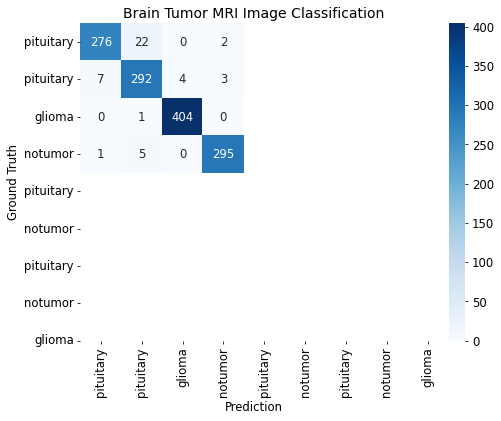

In [ ]:
cnf = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Image Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)